1. The reviews for most businesses on Yelp seem to be positively skewed. Majority of them have an aggregate rating of 4 and above.
2. On each review page for a business, there are 20 reviews and a link to the next page if it exists. Taking the limit of 1000 calls a maximum of 20,000 reviews can be obtained. These are added in two separate lists, based on their rating value. 
3. This seems like a good amount of data, however on average the ratio of negative and positive review count is 3:12. 
4. To get a balanced dataset, after this review data is extracted, the deficit observations are removed from the list of  positive reviews.  
5. The code for classifier is quite basic.

In [1]:
import requests
import json

import matplotlib.pyplot as plt
import numpy as np

import random

In [2]:
 from bs4 import BeautifulSoup

In [3]:
import random

In [4]:
import pandas as pd

In [5]:
import time

In [6]:
from nltk.sentiment import SentimentAnalyzer
import nltk.sentiment.util
from nltk.classify import NaiveBayesClassifier

In [7]:
YELP_TOKEN = ""

In [8]:
response = requests.get("https://api.yelp.com/v3/businesses/search?location=Toronto&limit=50", headers={"Authorization": "Bearer %s" % YELP_TOKEN})

In [9]:
print(response.status_code)

200


In [ ]:
#response.json()

In [11]:
businesses = response.json()['businesses']

In [12]:
len(businesses)

50

In [13]:
review_url = set()

In [14]:
#extracting the url of review page for all businesses
for business in businesses:
    reviews = requests.get("https://api.yelp.com/v3/businesses/%s/reviews" % business['id'], headers={"Authorization": "Bearer %s" % YELP_TOKEN}).json()
    if reviews['reviews'][0]['url'] not in review_url:
        review_url.add(reviews['reviews'][0]['url'])


In [16]:
len(review_url)

50

In [17]:
def extract_reviews(text_response):
    soup = BeautifulSoup(text_response,"html.parser")
    reviews = soup.contents[12].find_all(itemprop="review")
    return reviews

In [18]:
def get_next_url(text_response):
    soup = BeautifulSoup(text_response,"html.parser")
    next_url = soup.find(rel="next")
    return next_url

In [19]:
def get_response(url):
    global api_hit_counter
    print(url)
    response = requests.get(url)
    print( str(response.status_code))
    api_hit_counter += 1
    return (response, api_hit_counter)

In [20]:
#function to get same number of positive and negative reviews
#this will reduce the size of huge dataset as it is positively skewed, but a substantial amount can still be gathered
def get_data(response):
    reviews = extract_reviews(response.text)
    for review in reviews:
        rating = float(review.find(itemprop="ratingValue")['content'])
        review_text = review.p.text
        print("rating " + str(rating))
        if(rating > 3.0):
            if((len(positive_reviews) <= len(negative_reviews))):
                positive_reviews.append((review_text, rating))
        else:
            if(len(negative_reviews) <= len(positive_reviews)):
                negative_reviews.append((review_text, rating))

In [21]:
api_hit_limit = 949
api_hit_counter = 0

In [22]:
positive_reviews= []
negative_reviews = []

In [23]:
api_hit_counter

0

In [ ]:
#get reviews till hit limit is reached or time elapsed is 2 hours 
start_time = time.time()
for url in review_url:
    response, counter = get_response(url)
    get_data(response)
    while(get_next_url(response.text) != None):
        new_resp, new_counter = get_response(get_next_url(response.text).get("href")) 
        if((new_counter >= api_hit_limit) or ((time.time() - start_time) > 7200)):
            print("counter: " + str(new_counter) + "time: " + str(time.time()-start_time))
            break
        else:
            get_data(new_resp)
            response = new_resp

In [25]:
len(positive_reviews)

3137

In [26]:
len(negative_reviews)

3137

In [27]:
if (len(positive_reviews) > len(negative_reviews)):
    positive_reviews.pop(random.randint(0,len(positive_reviews)))
elif(len(negative_reviews) > len(positive_reviews)):
    negative_reviews.pop(random.randint(0,len(negative_reviews)))

In [28]:
review_labels=[]

In [29]:
positive_copy = positive_reviews.copy()

In [30]:
negative_copy = negative_reviews.copy()

In [31]:
(len(positive_copy), len(negative_copy))

(3137, 3137)

In [32]:
for i in range(len(positive_reviews)):
    review_labels.append(positive_reviews.pop(random.randint(0,len(positive_reviews)-1)))
    review_labels.append(negative_reviews.pop(random.randint(0,len(negative_reviews)-1)))

In [33]:
(len(positive_copy), len(negative_copy))

(3137, 3137)

In [34]:
review_labels

[("Definitely a gem.\n\nI've been here twice and both were amazing. \nWARNING: It does tend to get really noisy indoors. Try to get a seat out in patio as you can, you'll get a chance to actually talk to your company. \n\nBut otherwise, it's amazing. Amazing service, amazing food, amazing atmosphere. \n\nCarpaccio \nbeef tenderloin, truffled cannellini beans, pecorino, \nmicro greens (13.95) :\nBeautifully thin sliced carpaccio. It was amazing, I have no clue how they do it. 5/5. It is a small portion, however if you love carpaccio, you should definitely give this a try. \n\nPolipo \ngrilled octopus, olive tapenade, celery root puree, chorizo, pea \nshoots, smoked paprika emulsion (14.50):\nRecommended by the server. And now, recommended by me. This is actually a pretty decent serving, and as well, it's superb. The octopus is cooked lovely; not too chewy,but tough enough to give you a bit of a bite. \n\nSalmone alla Brace \nsalmon, quinoa, heirloom beet and carrot slaw, \nlemon, avocad

In [35]:
len(review_labels)

6274

In [36]:
review_features = [(x, 'positive' if y > 3 else 'negative') for (x, y) in review_labels]

In [37]:
review_features

[("Definitely a gem.\n\nI've been here twice and both were amazing. \nWARNING: It does tend to get really noisy indoors. Try to get a seat out in patio as you can, you'll get a chance to actually talk to your company. \n\nBut otherwise, it's amazing. Amazing service, amazing food, amazing atmosphere. \n\nCarpaccio \nbeef tenderloin, truffled cannellini beans, pecorino, \nmicro greens (13.95) :\nBeautifully thin sliced carpaccio. It was amazing, I have no clue how they do it. 5/5. It is a small portion, however if you love carpaccio, you should definitely give this a try. \n\nPolipo \ngrilled octopus, olive tapenade, celery root puree, chorizo, pea \nshoots, smoked paprika emulsion (14.50):\nRecommended by the server. And now, recommended by me. This is actually a pretty decent serving, and as well, it's superb. The octopus is cooked lovely; not too chewy,but tough enough to give you a bit of a bite. \n\nSalmone alla Brace \nsalmon, quinoa, heirloom beet and carrot slaw, \nlemon, avocad

In [38]:
with open('review_data.json', 'w', encoding='utf-8') as f:
    json.dump(review_features, f, ensure_ascii=False, indent=4)

In [39]:
review_features = [(x.split(' '), y) for (x, y) in review_features]

In [40]:
review_features

[(['Definitely',
   'a',
   "gem.\n\nI've",
   'been',
   'here',
   'twice',
   'and',
   'both',
   'were',
   'amazing.',
   '\nWARNING:',
   'It',
   'does',
   'tend',
   'to',
   'get',
   'really',
   'noisy',
   'indoors.',
   'Try',
   'to',
   'get',
   'a',
   'seat',
   'out',
   'in',
   'patio',
   'as',
   'you',
   'can,',
   "you'll",
   'get',
   'a',
   'chance',
   'to',
   'actually',
   'talk',
   'to',
   'your',
   'company.',
   '\n\nBut',
   'otherwise,',
   "it's",
   'amazing.',
   'Amazing',
   'service,',
   'amazing',
   'food,',
   'amazing',
   'atmosphere.',
   '\n\nCarpaccio',
   '\nbeef',
   'tenderloin,',
   'truffled',
   'cannellini',
   'beans,',
   'pecorino,',
   '\nmicro',
   'greens',
   '(13.95)',
   ':\nBeautifully',
   'thin',
   'sliced',
   'carpaccio.',
   'It',
   'was',
   'amazing,',
   'I',
   'have',
   'no',
   'clue',
   'how',
   'they',
   'do',
   'it.',
   '5/5.',
   'It',
   'is',
   'a',
   'small',
   'portion,',
   'howev

In [41]:
len(review_features)

6274

<BarContainer object of 5 artists>

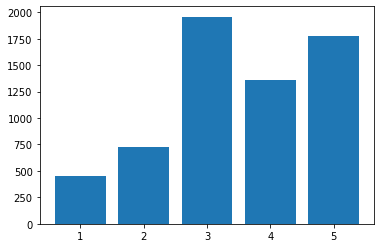

In [42]:
from collections import defaultdict

c = defaultdict(int)
for x in review_labels:
    c[x[1]] += 1

plt.bar(c.keys(), c.values())

In [43]:
index_to_split = int(len(review_features)*0.75)

In [44]:
index_to_split

4705

In [45]:
random.shuffle(review_features)
training_docs = review_features[:index_to_split]
test_docs = review_features[index_to_split:]

print("Training: %d, Testing: %d" % (len(training_docs), len(test_docs)))

sentim_analyzer = SentimentAnalyzer()

Training: 4705, Testing: 1569


In [46]:
all_words_neg = sentim_analyzer.all_words([nltk.sentiment.util.mark_negation(doc) for doc in training_docs])
all_words_neg

["It's",
 'Winterlicious',
 'season!!',
 '\nMy',
 'boyfriend',
 'and',
 'I',
 'revisited',
 'Miku',
 'to',
 'try',
 'out',
 'their',
 'Winterlicious',
 'menu.',
 'Miku',
 'is',
 'now',
 'officially',
 'my',
 'favourite',
 'Japanese',
 'restaurant',
 'in',
 'Toronto!!',
 'The',
 'menu',
 'items',
 'were',
 'the',
 'dishes',
 'that',
 'we',
 'liked',
 'from',
 'our',
 'last',
 'visit',
 'and',
 'this',
 'was',
 'sooo',
 'worth',
 'it',
 ':)',
 'The',
 'menu',
 'was',
 '$48pp',
 'which',
 'includes',
 'appetizer,',
 'entrée',
 'and',
 'dessert',
 '(3',
 'options',
 'to',
 'choose',
 'from',
 'each',
 'category).',
 'Service',
 'was',
 'excellent.',
 'Our',
 'server',
 'was',
 'very',
 'friendly.\n\nDRINKS:\n*',
 'Stoneburn',
 'Sauvignon',
 'Blanc',
 '(mine)',
 '\n*',
 'Underwood',
 'Pinot',
 'Noir',
 '(his)\n\nAppetizer:\n\n*',
 'MIKU',
 'SIGNATURE',
 'ABURI',
 'SUSHI',
 'SELECTION',
 '(5/5)\n(salmon,',
 'ebi,',
 'coal',
 'harbour',
 'roll,',
 'queens',
 'quay',
 'roll,',
 'aburi',
 'nigi

In [47]:
unigram_feats = sentim_analyzer.unigram_word_feats(all_words_neg, min_freq=4)
sentim_analyzer.add_feat_extractor(nltk.sentiment.util.extract_unigram_feats, unigrams=unigram_feats)

In [48]:
training_set = sentim_analyzer.apply_features(training_docs)
test_set = sentim_analyzer.apply_features(test_docs)

In [49]:
trainer = NaiveBayesClassifier.train
classifier = sentim_analyzer.train(trainer, training_set)
for key,value in sorted(sentim_analyzer.evaluate(test_set).items()):
     print('{0}: {1}'.format(key, value))

Training classifier
Evaluating NaiveBayesClassifier results...
Accuracy: 0.6277884002549394
F-measure [negative]: 0.6010928961748634
F-measure [positive]: 0.6511350059737157
Precision [negative]: 0.6779661016949152
Precision [positive]: 0.592391304347826
Recall [negative]: 0.5398773006134969
Recall [positive]: 0.7228116710875332
